# **Applying DCGAN on CIFAR10 Dataset**

# **Import neccesary Libraries**

In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

# **Load and view the data**

In [ ]:

# Load the CIFAR10 data
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

# Display the shapes of the train_images and train_labels
train_images_shape = train_images.shape
train_labels_shape = train_labels.shape

train_images_shape, train_labels_shape


170498071/170498071 [==============================] - 6s 0us/step


((50000, 32, 32, 3), (50000, 1))

# **Preprocessing**

# **Normalization**

In [ ]:


# Normalize the images to [-1, 1]
min_before = np.min(train_images)  # Minimum value before normalization
max_before = np.max(train_images)  # Maximum value before normalization

train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5

min_after = np.min(train_images)  # Minimum value after normalization
max_after = np.max(train_images)  # Maximum value after normalization

print("Before Normalization:", min_before, max_before)
print("After Normalization:", min_after, max_after)


Before Normalization: 0 255
After Normalization: -1.0 1.0


# **Initializing Parameters and Shuffling the dataset**

In [ ]:
BUFFER_SIZE = 50000  # CIFAR10 has 50,000 images in the training set
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Print the shape of the dataset
for images_batch in train_dataset.take(1):
    print(images_batch.shape)

(256, 32, 32, 3)


# **Generator Architecture**

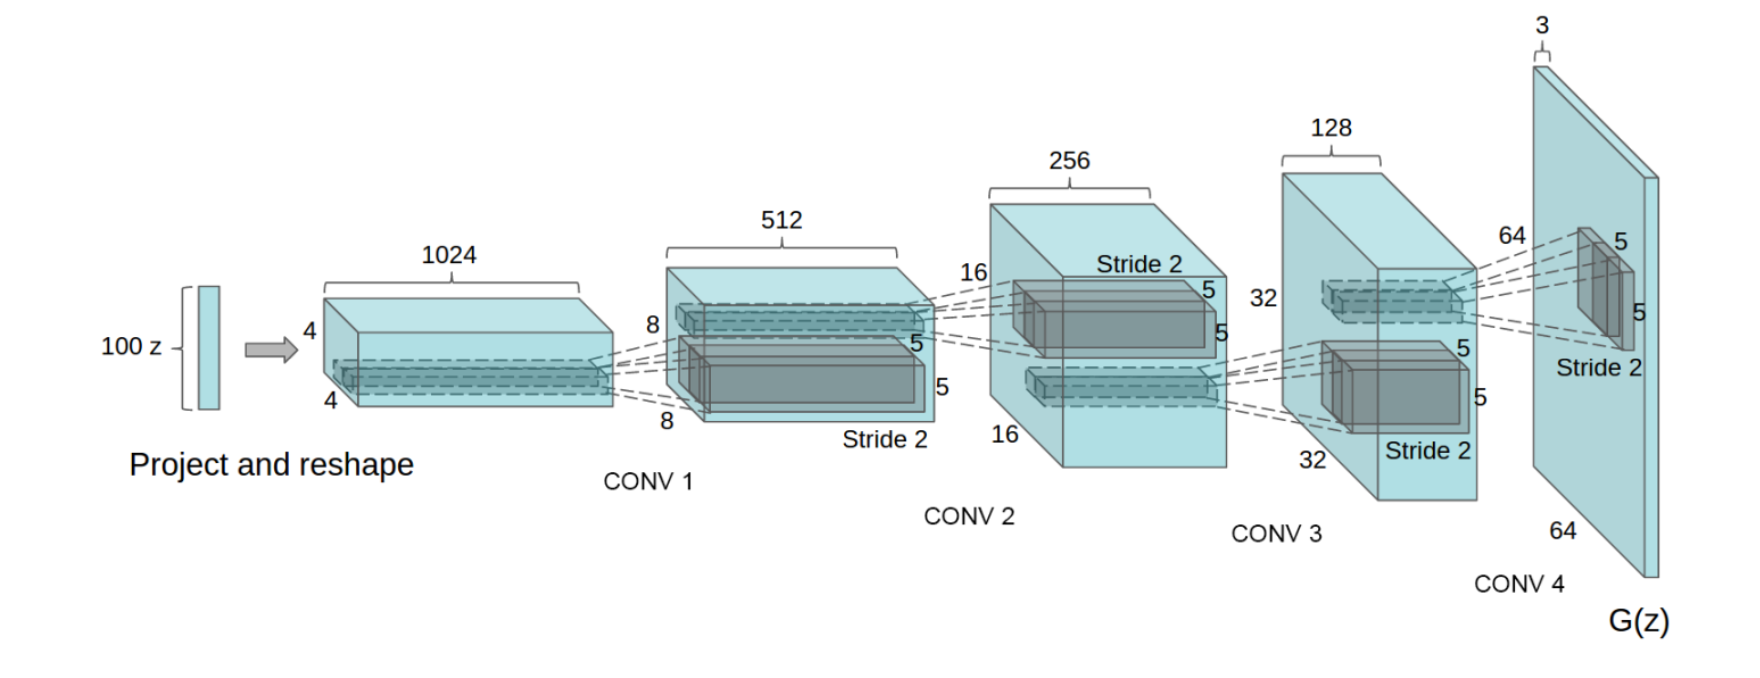

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    # The input to the model is a 100-dimensional noise vector (z).
    # This vector will be projected to a higher dimensional space and reshaped.
    # The Dense layer will have 4*4*1024 units, which will be reshaped to a 4x4x1024 tensor.
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    # Batch normalization stabilizes training by normalizing the output of the dense layer.
    model.add(layers.BatchNormalization())
    # LeakyReLU allows for a small gradient when the unit is inactive, which helps during training.
    model.add(layers.LeakyReLU())

    # Reshape the output of the Dense layer to a 4x4x1024 tensor to start the convolutional process.
    model.add(layers.Reshape((4, 4, 1024)))

    # First transposed convolutional layer.
    # Conv2DTranspose with 512 filters, a 5x5 kernel size, and a stride of 2 to double the tensor size.
    # Output shape becomes 8x8x512.
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second transposed convolutional layer.
    # Further upsampling the tensor size to 16x16x256.
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third transposed convolutional layer.
    # Final upsampling to match the training data size, resulting in a 32x32x128 tensor.
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final transposed convolutional layer.
    # This layer outputs a 32x32x3 tensor, matching the training data shape and size.
    # The 'tanh' activation function is used to ensure the output values are between -1 and 1.
    # Since the desired output size is already 32x32, we use a stride of 1 to maintain it.
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

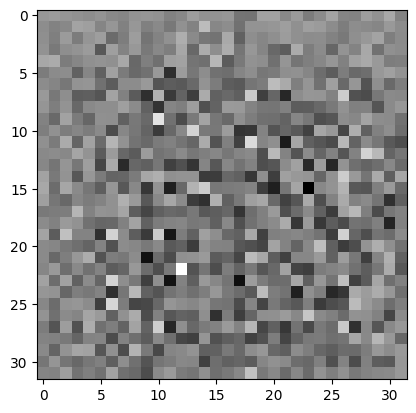

In [ ]:
# Instantiate the generator model
generator = make_generator_model()

# Generate a batch of noise input (latent space) to feed to the generator
noise = tf.random.normal([1, 100])

# Generate an image from the noise vector (without training the generator)
generated_image = generator(noise, training=False)

# Display the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

plt.show()



In [ ]:

# Output the summary of the generator model to see the architecture and parameters
generator.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_12 (Ba  (None, 16384)             65536     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 8, 8, 512)         13107200  
 DTranspose)                                                     
                                                                 
 batch_normalization_13 (Ba  (None, 8, 8, 512)        

# **Discriminator Architecture**

In [ ]:




def make_discriminator_model():
    model = tf.keras.Sequential()
    # First convolutional layer, input_shape is for CIFAR10 images
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second convolutional layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third convolutional layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten the output to feed into a dense layer
    model.add(layers.Flatten())
    # Output dense layer with a single neuron to classify fake vs real images
    model.add(layers.Dense(1))

    return model
import tensorflow as tf
from tensorflow.keras import layers

def make_discriminator_model():
    model = tf.keras.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second convolutional layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third convolutional layer
    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))  # Stride is now 1 to avoid over-reducing dimensions
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Fourth convolutional layer
    model.add(layers.Conv2D(512, (5, 5), strides=(1, 1), padding='same'))  # Maintaining stride of 1
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Fifth convolutional layer
    model.add(layers.Conv2D(512, (5, 5), strides=(1, 1), padding='same'))  # Same number of filters and stride
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Sixth convolutional layer
    model.add(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))  # Reduced kernel size to focus on more local features
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten the output to feed into a dense layer
    model.add(layers.Flatten())

    # Output dense layer with a single neuron to classify fake vs real images
    model.add(layers.Dense(1))

    return model

# Create the discriminator model
discriminator = make_discriminator_model()


In [ ]:
# Create the discriminator model for CIFAR10
discriminator = make_discriminator_model()

# Display the model summary to see the architecture
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

In [ ]:

# The discriminator takes an image as input and outputs a decision.
# Here, it's fed a generated image (from the generator model) to assess whether the image is real or fake.
# The 'decision' variable will contain the discriminator's output.
decision = discriminator(generated_image)

# Print out the decision of the discriminator.
# The value is typically a single scalar obtained from the last dense layer of the discriminator.
# If the discriminator is well-trained, positive values indicate a classification of 'real',
# while negative values indicate 'fake'. However, without training, these values do not hold
# any particular significance and are just the untrained discriminator's raw output.
print(decision)


tf.Tensor([[0.00064157]], shape=(1, 1), dtype=float32)


# **Defining loss function**

In [ ]:
# Instantiate a BinaryCrossentropy loss function configured to work with logits.
# This will be used to compare the discriminator's predictions against the true labels (real or fake).
# The 'from_logits=True' parameter indicates that the predictions passed to this function are
# raw scores (logits) rather than probabilities.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


# **Discriminator Loss**

In [ ]:
def discriminator_loss(real_output, fake_output):
    # Calculate the loss for the real images.
    # real_output is the discriminator's prediction scores for real images.
    # We want these predictions to be close to 1 (indicating 'real'), so we compare them to a tensor of 1s.
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # Calculate the loss for the fake images.
    # fake_output is the discriminator's prediction scores for fake (generated) images.
    # We want these predictions to be close to 0 (indicating 'fake'), so we compare them to a tensor of 0s.
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # The total loss is the sum of the real_loss and the fake_loss.
    # This total loss tells us how well the discriminator can distinguish real images from fake ones.
    total_loss = real_loss + fake_loss
    return total_loss


# **Generator Loss**

In [ ]:
def generator_loss(fake_output):
    # Compute the generator loss based on the discriminator's output for the generated (fake) images.
    # fake_output is the discriminator's prediction scores for the fake images.

    # The generator's objective is to have its generated (fake) images be classified as real by the discriminator.
    # To achieve this, it tries to make the discriminator's predictions for the fake images (fake_output) be close to 1.
    # Therefore, we compare the discriminator's predictions for the fake images against a tensor of 1s.
    # A lower loss indicates that the generator is doing a better job at fooling the discriminator.
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# **Defining Optimizers**

In [ ]:

# Initialize the optimizer for the generator.
# Adam optimizer is commonly used in training neural networks.
# The learning rate is set to 0.0001, which determines how large the step sizes are during gradient descent.
# A smaller learning rate means the updates to the weights are more subtle, which can be beneficial
# for fine-grained updates, especially in complex models like GANs.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Initialize the optimizer for the discriminator.
# We use the same optimizer and learning rate as the generator for simplicity and to keep the training balanced.
# In practice, these could be adjusted separately if needed to achieve better training dynamics.
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


# **Saving Checkpoints**

In [ ]:
import os
import tensorflow as tf

# Define the directory where the checkpoints will be saved.
checkpoint_dir = './training_checkpoints'

# Define the prefix for the checkpoint files. TensorFlow will append the checkpoint number to this prefix.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a Checkpoint that will manage the state of the model as well as the optimizers.
# This allows us to save the state of the training process and resume from where we left off, which is
# especially helpful in case the training process gets interrupted or when we wish to use the trained model later on.
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


# **Defining Parameters for Model Training**

In [ ]:
# Number of epochs for which the GAN should be trained.
# An epoch is one complete pass through the entire training dataset.
EPOCHS = 450

# Dimensionality of the latent space from which the generator will produce images.
# The generator will take a noise vector of this length as input.
noise_dim = 100

# Number of examples to generate for visualization purposes.
# This is how many fake images we will generate to observe the generator's progress.
num_examples_to_generate = 32

# Generate a seed vector. This seed will be reused to generate images periodically during training,
# allowing us to see how the generator's output develops over time.
# The seed is a tensor of shape [num_examples_to_generate, noise_dim] containing normal-distributed random values.
seed = tf.random.normal([num_examples_to_generate, noise_dim])


# **Defining Train Step and Train Methods**

In [ ]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# **Defining Save Image method**

In [ ]:


def generate_and_save_images(model, epoch, test_input):
    # Generate images from the input noise vector and model in inference mode
    predictions = model(test_input, training=False)

    # Create a figure for plotting
    fig = plt.figure(figsize=(8, 16))  # Width, Height in inches

    # The number of images you want to display
    num_images = predictions.shape[0]

    # Number of columns is 4 as you requested 4 images per row
    num_columns = 4

    # Calculate the number of rows to display all the images
    num_rows = (num_images + num_columns - 1) // num_columns  # Ceiling division

    for i in range(num_images):
        plt.subplot(num_rows, num_columns, i+1)
        image = predictions[i, :, :, :] * 0.5 + 0.5  # Rescale pixel values to [0, 1]
        plt.imshow(image)
        plt.axis('off')

    # Save the figure containing all the images to a file
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()



# **Training the DCGAN model**

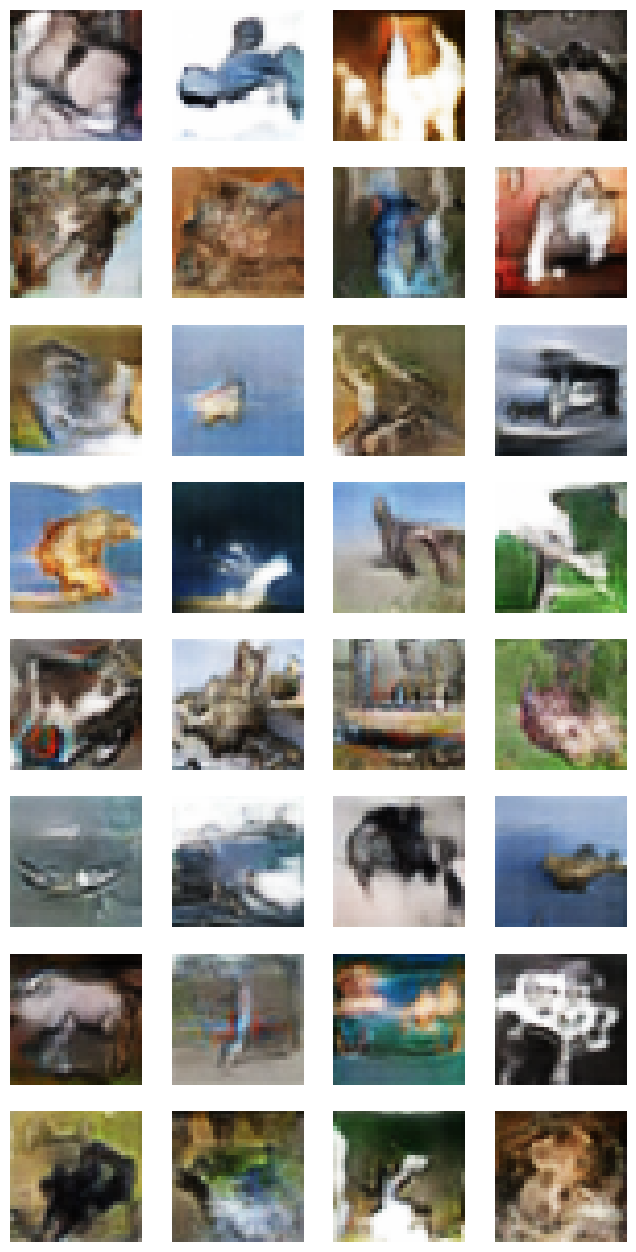

In [ ]:
train(train_dataset, EPOCHS)

# **Evaluating VAE Performance and Mode Collapse with 32 Generated Images**




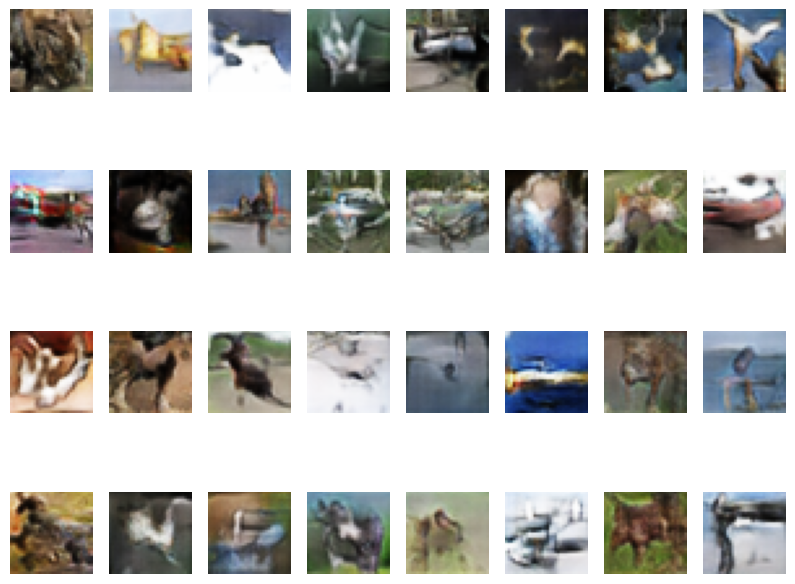

In [ ]:


def generate_and_save_images(model, test_input, epoch):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 8, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)  # rescale to [0, 1]
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Seed for generating the images
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Generate and save images
generate_and_save_images(generator, seed, epoch=0)



 **Each row of images shown above seems to depict distinct subjects, which implies that the model is generating a variety of images, a positive sign that mode collapse is not occurring. Even though the clarity of the images isn't perfect, there is an observable improvement with each epoch, which is promising. Training the model for 450 epochs has led to some improvement, but due to resource constraints, it wasn't possible to continue training. With additional epochs, the generated images are expected to improve, becoming more defined and clear, and capturing the details of CIFAR-10 classes more accurately. This enhancement will also help provide more definitive proof regarding the absence of mode collapse.**